Loading file: /home/ahmed/ahsan/nas-wireless/dataset/outputs/umi_compact_8Tx_2Rx.mat
Available keys in the file: ['#refs#', 'cfg', 'channel_matrix']
Loaded channel matrix shape: (256, 8, 18, 2, 500)
Data type: [('real', '<f4'), ('imag', '<f4')]
Complex data stored in compound format, attempting to convert...
Fields in the compound type: ('real', 'imag')
Converted shape: (256, 8, 18, 2, 500)
New data type: complex64
Selecting: UE=0, Time=0, RX=0
Channel slice shape: (18, 8)
Saved visualization to channel_visualization.png


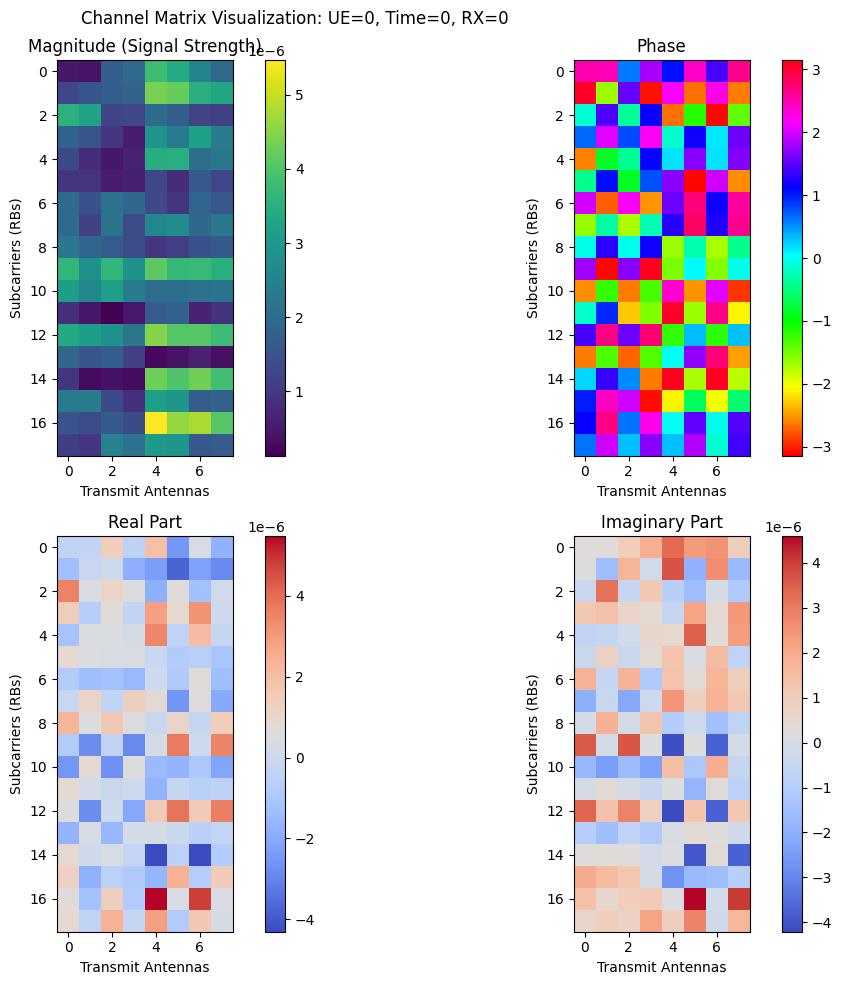

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# File path - change this to your .mat file path
filename = "/home/ahmed/ahsan/nas-wireless/dataset/outputs/umi_compact_8Tx_2Rx.mat"

# Load the .mat file
print(f"Loading file: {filename}")
with h5py.File(filename, 'r') as f:
    # Print available keys to understand the structure
    print("Available keys in the file:", list(f.keys()))
    
    # Load the channel matrix
    channel_matrix = f['channel_matrix'][:]
    print(f"Loaded channel matrix shape: {channel_matrix.shape}")
    
    # Print data type information
    print(f"Data type: {channel_matrix.dtype}")

# If the data type is a void/compound type, we need to extract the complex values
if channel_matrix.dtype.kind == 'V':  # Check if it's a void/compound type
    # Try to extract real and imaginary parts
    print("Complex data stored in compound format, attempting to convert...")
    
    # Get field names
    print(f"Fields in the compound type: {channel_matrix.dtype.names}")
    
    # Try different approaches to convert to complex numbers
    try:
        # Method 1: If stored as 'real' and 'imag' fields
        if 'real' in channel_matrix.dtype.names and 'imag' in channel_matrix.dtype.names:
            real_part = channel_matrix['real']
            imag_part = channel_matrix['imag']
            channel_matrix = real_part + 1j * imag_part
        
        # Method 2: If stored as 're' and 'im' fields
        elif 're' in channel_matrix.dtype.names and 'im' in channel_matrix.dtype.names:
            real_part = channel_matrix['re']
            imag_part = channel_matrix['im']
            channel_matrix = real_part + 1j * imag_part
            
        # Method 3: View as complex array
        else:
            # This is a more direct conversion if the byte layout is compatible
            channel_matrix = channel_matrix.view(np.complex64)
            
        print(f"Converted shape: {channel_matrix.shape}")
        print(f"New data type: {channel_matrix.dtype}")
        
    except Exception as e:
        print(f"Conversion failed: {e}")
        # If conversion fails, try to print more details about the data
        print("First element sample:", channel_matrix.flat[0])
        raise

# Based on your error message, the dimensions are: (256, 8, 18, 2, 500)
# This suggests: [UE, TX, RB, RX, Time]
# We'll adjust our indexing accordingly

# Parameters for visualization
ue_idx = 0      # User equipment index
time_idx = 0    # Time sample index
rx_idx = 0      # Receive antenna index

# Make sure indices are within bounds
max_ue = channel_matrix.shape[0] - 1
max_tx = channel_matrix.shape[1] - 1
max_rb = channel_matrix.shape[2] - 1
max_rx = channel_matrix.shape[3] - 1
max_time = channel_matrix.shape[4] - 1

time_idx = min(time_idx, max_time)
rx_idx = min(rx_idx, max_rx)
ue_idx = min(ue_idx, max_ue)

print(f"Selecting: UE={ue_idx}, Time={time_idx}, RX={rx_idx}")

# Extract the slice - adjust dimensions based on your data structure
# We want RB x TX (18 x 8) so we index: [UE, :, :, RX, Time]
channel_slice = channel_matrix[ue_idx, :, :, rx_idx, time_idx]

# Transpose to get RB x TX (18 x 8) instead of TX x RB (8 x 18)
channel_slice = channel_slice.T
print(f"Channel slice shape: {channel_slice.shape}")  # Should be (18, 8)

# Extract different components of the complex channel
magnitude = np.abs(channel_slice)      # Signal strength
phase = np.angle(channel_slice)        # Phase information
real_part = np.real(channel_slice)     # Real part
imag_part = np.imag(channel_slice)     # Imaginary part

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Magnitude plot (signal strength)
mag_plot = axes[0, 0].imshow(magnitude, cmap='viridis')
axes[0, 0].set_title('Magnitude (Signal Strength)')
axes[0, 0].set_xlabel('Transmit Antennas')
axes[0, 0].set_ylabel('Subcarriers (RBs)')
plt.colorbar(mag_plot, ax=axes[0, 0])

# Phase plot
phase_plot = axes[0, 1].imshow(phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title('Phase')
axes[0, 1].set_xlabel('Transmit Antennas')
axes[0, 1].set_ylabel('Subcarriers (RBs)')
plt.colorbar(phase_plot, ax=axes[0, 1])

# Real part plot
real_plot = axes[1, 0].imshow(real_part, cmap='coolwarm')
axes[1, 0].set_title('Real Part')
axes[1, 0].set_xlabel('Transmit Antennas')
axes[1, 0].set_ylabel('Subcarriers (RBs)')
plt.colorbar(real_plot, ax=axes[1, 0])

# Imaginary part plot
imag_plot = axes[1, 1].imshow(imag_part, cmap='coolwarm')
axes[1, 1].set_title('Imaginary Part')
axes[1, 1].set_xlabel('Transmit Antennas')
axes[1, 1].set_ylabel('Subcarriers (RBs)')
plt.colorbar(imag_plot, ax=axes[1, 1])

plt.suptitle(f"Channel Matrix Visualization: UE={ue_idx}, Time={time_idx}, RX={rx_idx}")
plt.tight_layout()
plt.savefig("channel_visualization.png", dpi=300)
print("Saved visualization to channel_visualization.png")
plt.show()

In [9]:
# --------------------------------------------------------------
# test_dataloader.py  –  sanity-check the *new* dataloader
# --------------------------------------------------------------
import sys
import os
import torch

# ------------------------------------------------------------------ #
# 1)  Ensure Python can find your local “dataloader.py”
# ------------------------------------------------------------------ #
dataloader_directory = "/home/ahmed/ahsan/nas-wireless/baseline_models/"
if dataloader_directory not in sys.path:
    sys.path.insert(0, dataloader_directory)

from dataloader import get_all_datasets           # import after path tweak

# ------------------------------------------------------------------ #
# 2)  Experiment settings
# ------------------------------------------------------------------ #
device                 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size             = 16
dataset_id_to_test     = "all"                         # 1 | 2 | 3 | "all"
data_dir               = "/home/ahmed/ahsan/nas-wireless/dataset/outputs/"

# one of:  'min_max', 'z_score', 'log_min_max', 'robust',
#          'global_max', 'sqrt_min_max', 'clip_db'
normalization_choice   = "log_min_max"                  # 'clip_db' is the default
per_user_normalization = True                     # True → per-user, False → global

print(
    f"\n--- Loading dataset {dataset_id_to_test} with "
    f"normalisation = '{normalization_choice}' "
    f"({'per-user' if per_user_normalization else 'global'}) ---"
)

# ------------------------------------------------------------------ #
# 3)  Load dataset(s)
# ------------------------------------------------------------------ #
(
    train_S1, test_S1, train_loader_S1, test_loader_S1,
    train_S2, test_S2, train_loader_S2, test_loader_S2,
    train_S3, test_S3, train_loader_S3, test_loader_S3
) = get_all_datasets(
        data_dir      = data_dir,
        batch_size    = batch_size,
        dataset_id    = dataset_id_to_test,
        normalization = normalization_choice,
        per_user      = per_user_normalization,
        seq_len       = 64,               # window length
        # clip_db_floor = -100, clip_db_ceil = -30  # only for 'clip_db'
    )

# ------------------------------------------------------------------ #
# 4)  Quick sanity check (Dataset-1 only)
# ------------------------------------------------------------------ #
print("\n--- DataLoader Batch Check ---")
loader_to_test = train_loader_S1
assert loader_to_test is not None, "Dataset 1 loader is None – did it load?"

batch_inp, batch_out = next(iter(loader_to_test))
print("Loaded one batch successfully.")
print(f"Input  batch shape : {batch_inp.shape}")   # (B, Rx, Sub, Tx, seq_len)
print(f"Output batch shape : {batch_out.shape}")   # (B, Rx, Sub, Tx)

print("\n--- Normalisation stats on batch ---")
print(f"input  min / mean / max : "
      f"{batch_inp.min():.4f} / {batch_inp.mean():.4f} / {batch_inp.max():.4f}")
print(f"output min / mean / max : "
      f"{batch_out.min():.4f} / {batch_out.mean():.4f} / {batch_out.max():.4f}")

# ------------------------------------------------------------------ #
# 5)  Inspect first sample & first-few timesteps
# ------------------------------------------------------------------ #
sample_inp = batch_inp[0]
print("\n--- First sample stats ---")
print(f"sample-inp min / mean / max = "
      f"{sample_inp.min():.4f} / {sample_inp.mean():.4f} / {sample_inp.max():.4f}")

print("\nFirst 10 values of sample input "
      "(Rx-0, Sub-0, Tx-0, first-10 time-steps):")
print(sample_inp[0, 0, 0, :10].cpu().numpy())

# ------------------------------------------------------------------ #
# 6)  Show auto-scaling gain for debugging
# ------------------------------------------------------------------ #
root_ds = train_S1.dataset          # Subset → underlying ChannelSequenceDataset
stats   = root_ds.get_stats()
if stats["per_user"]:
    g_min, g_max = min(stats["gains"]), max(stats["gains"])
    print(f"\nAuto-gain range per user : {g_min:.1e} – {g_max:.1e}")
else:
    print(f"\nGlobal auto-gain applied : {stats['gain']:.1e}")
    
    # percentage of zeros in the input batch
zero_ratio = (batch_inp == 0).float().mean().item()
print(f"\nShare of exact zeros in batch_inp: {zero_ratio*100:.2f}%")

# percentage in the whole cube (expensive -- do once):
cube = train_S1.dataset.data      # underlying numpy array
zero_ratio_cube = (cube == 0).mean()
print(f"Share of exact zeros in entire dataset: {zero_ratio_cube*100:.2f}%")
rx, sub, tx = 0, 0, 0
non_zero_ts = sample_inp[rx, sub, tx, :].nonzero(as_tuple=True)[0]
print("First 10 non-zero time slots:", non_zero_ts[:10].cpu().numpy())
print("Values:", sample_inp[rx, sub, tx, non_zero_ts[:10]].cpu().numpy())



Using device: cuda

--- Loading dataset all with normalisation = 'log_min_max' (per-user) ---
→ Loading Dataset 1: /home/ahmed/ahsan/nas-wireless/dataset/outputs/umi_fixed_compact_8Tx_2Rx.mat
Loaded raw cube : (256, 32, 18, 2, 500)
Raw magnitude: min=0.0000e+00  max=6.6792e-05  mean=2.6360e-07
Per-user auto gain : 1.0e+05 – 1.0e+07
After auto-scale: min=0.0000e+00  max=9.8836e+00  mean=1.3524e-01
After normalisation: min=0.0000e+00  max=1.0000e+00  mean=1.5177e-01
→ Loading Dataset 2: /home/ahmed/ahsan/nas-wireless/dataset/outputs/umi_fixed_dense_8Tx_2Rx.mat
Loaded raw cube : (256, 32, 18, 2, 500)
Raw magnitude: min=0.0000e+00  max=4.9120e-05  mean=9.7678e-08
Per-user auto gain : 1.0e+05 – 1.0e+08
After auto-scale: min=0.0000e+00  max=9.9695e+00  mean=1.5155e-01
After normalisation: min=0.0000e+00  max=1.0000e+00  mean=1.4976e-01
→ Loading Dataset 3: /home/ahmed/ahsan/nas-wireless/dataset/outputs/umi_fixed_standard_8Tx_2Rx.mat
Loaded raw cube : (256, 32, 18, 2, 500)
Raw magnitude: min=

In [8]:
#!/usr/bin/env python
# count_zeros_in_channel.py
import h5py
import numpy as np
import os

# ------------------------------------------------------------
# 1)  Path to the .mat file
# ------------------------------------------------------------
fname = "/home/ahmed/ahsan/nas-wireless/dataset/outputs/umi_fixed_standard_8Tx_2Rx.mat"
assert os.path.isfile(fname), f"File not found: {fname}"

# ------------------------------------------------------------
# 2)  Load real/imag parts (works with both layouts you use)
# ------------------------------------------------------------
with h5py.File(fname, "r") as f:
    if "channel_matrix" in f:                     # preferred structure
        grp  = f["channel_matrix"]
        real = np.array(grp["real"])
        imag = np.array(grp["imag"])
    else:                                         # flat keys
        real = np.array(f["real"])
        imag = np.array(f["imag"])

# real.shape == (U, 32, 18, 2, 500)
print("Loaded cube shape :", real.shape)

# ------------------------------------------------------------
# 3)  Count exact zeros
# ------------------------------------------------------------
zero_mask = (real == 0) & (imag == 0)             # both parts exactly zero
n_zeros   = zero_mask.sum()
n_total   = np.prod(real.shape)
ratio     = n_zeros / n_total

print(f"Exact-zero values : {n_zeros:,d}  /  {n_total:,d} "
      f"({ratio*100:.2f} %)")


Loaded cube shape : (256, 32, 18, 2, 500)
Exact-zero values : 123,568,128  /  147,456,000 (83.80 %)
